<a href="https://colab.research.google.com/github/rennyatwork/CegepSteFoy_ReinfLearn_Work/blob/main/TP01/taxi_dqn_v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium
#!pip install segment_tree

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 6.2 MB/s eta 0:00:00


In [4]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from collections import deque
import random
import matplotlib.pyplot as plt

# Environment Setup
env = gym.make('Taxi-v3', render_mode="rgb_array")
state_size = env.observation_space.n  # Taxi-v3 has 500 states
action_size = env.action_space.n

# DQN Model
class DQNModel:
    def __init__(self, state_size, action_size):
        self.model = self._build_model(state_size, action_size)
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())

    def _build_model(self, state_size, action_size):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(state_size,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(action_size, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='mse')
        return model

    def predict(self, state):
        print('[BEGIN predict]')
        #print(f'[state] : {state} ')
        # Ensure state is passed as a numpy array with the correct dimensions
        if np.isscalar(state):
            state = np.eye(state_size)[state]  # Convert scalar to one-hot encoded array
        else:
            assert state.shape == (state_size,), f"Input shape mismatch, got {state.shape}, expected {(state_size,)}"
        print('[END predict]')
        return self.model.predict(np.array([state]), verbose = 0)[0]
        #return self.model.__call__(np.array([state]))[0]

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())




# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.005
        self.epsilon_decay = 0.995
        self.model = DQNModel(state_size, action_size)
        self.update_target_model()

    def update_target_model(self):
        print('[BEGIN update_target_model]')
        self.model.update_target_model()
        print('[END update_target_model]')

    def remember(self, state, action, reward, next_state, done, pPrint=False):
        print('[BEGIN remember]')
        if pPrint:

            print(f'[state]: {state}')
            print(f'[action]: {action}')
            print(f'[reward]: {reward}')
            print(f'[next_state]: {next_state}')
            print(f'[done]: {done}')
        state = np.eye(self.state_size)[state] if isinstance(state, int) else state
        next_state = np.eye(self.state_size)[next_state] if isinstance(next_state, int) else next_state
        self.memory.append((state, action, reward, next_state, done))
        print('[END remember]')

    ### policy epsilon-greedy
    def act(self, state):
        print('[BEGIN act (policy)]')
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        #act_values = self.model.__call__(state)
        print('[END act]')
        return np.argmax(act_values)

    def replay(self, batch_size):
      print('[BEGIN replay]')
      minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
      for state, action, reward, next_state, done in minibatch:
          target = self.model.predict(state)
          #target = self.model.__call__(state)

          if done:
              target[action] = reward
          else:
              # Double DQN Logic:
              # 1. Use online network to select the best action in the next state
              best_action = np.argmax(self.model.predict(next_state))
              # 2. Use target network to estimate the Q-value of that best action
              target[action] = reward + self.gamma * self.model.target_model.predict(next_state)[0][best_action]
              #target[action] = reward + self.gamma * self.model.target_model.__call__(next_state)[0][best_action]

          # Update the model for the current batch
          self.model.model.fit(np.array([state]), np.array([target]), epochs=1, verbose=0)

      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay
      print('[END replay]')




    def replay(self, batch_size):
      print('[BEGIN replay]')
      minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
      for state, action, reward, next_state, done in minibatch:
          target = self.model.predict(state)  # Predict Q-values for the current state
          #target = self.model.__call__(state)  # Predict Q-values for the current state

          if done:
              target[action] = reward  # If done, target is just the reward
          else:
              # Double DQN Logic:
              # 1. Use online network to select the best action in the next state
              best_action = np.argmax(self.model.predict(next_state))
              #best_action = np.argmax(self.model.__call__(next_state))
              # 2. Use target network to estimate the Q-value of that best action
              next_state_reshaped = next_state.reshape(1, -1)  # Reshape next_state for target_model
              target[action] = reward + self.gamma * self.model.target_model.predict(next_state_reshaped, verbose=0)[0][best_action]
              #target[action] = reward + self.gamma * self.model.target_model.__call__(next_state_reshaped, verbose=0)[0][best_action]

          # Update the model for the current batch
          state_reshaped = state.reshape(1, -1)  # Reshape state before fitting
          self.model.model.fit(state_reshaped, np.array([target]), epochs=1, verbose=0)

      if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay
      print('[END replay]')


    def train(self, episodes, batch_size):
        print('[BEGIN train]')
        scores = []
        for e in range(episodes):
            print('')
            print(f'----------------------------------------- ')
            print(f'Episode {e} ')
            state = env.reset()
            state = state[0] if isinstance(state, tuple) else state  # Handle tuple output if it's possible in newer gym versions
            done = False
            score = 0

            iter=0
            while not done and iter <10:
                print(f'iter: {iter}')
                iter+=1

                action = self.act(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                reward = reward if not done else -10  # Penalize for not solving the environment

                self.remember(state, action, reward, next_state, done)
                state = next_state
                score += reward

                print(f'[epidosde] {e} - [iter] {iter}  - [ score ] : {score}')
                if done :
                    scores.append(score)
                    print(f"Episode: {e}/{episodes}, Score: {score}, Epsilon: {self.epsilon:.2}")
                    if e % 10 == 0:
                        self.update_target_model()
                    break

                # Call replay every 7 iterations instead of every action
                if len(self.memory) > batch_size and iter % 7 == 0:
                    self.replay(batch_size)
        print('[END train]')

        return scores

[BEGIN update_target_model]
[END update_target_model]
[BEGIN train]

----------------------------------------- 
Episode 0 
iter: 0
[BEGIN act (policy)]
[BEGIN remember]
[END remember]
[epidosde] 0 - [iter] 1  - [ score ] : -1
iter: 1
[BEGIN act (policy)]
[BEGIN remember]
[END remember]
[epidosde] 0 - [iter] 2  - [ score ] : -2
iter: 2
[BEGIN act (policy)]
[BEGIN remember]
[END remember]
[epidosde] 0 - [iter] 3  - [ score ] : -3
iter: 3
[BEGIN act (policy)]
[BEGIN remember]
[END remember]
[epidosde] 0 - [iter] 4  - [ score ] : -13
iter: 4
[BEGIN act (policy)]
[BEGIN remember]
[END remember]
[epidosde] 0 - [iter] 5  - [ score ] : -23
iter: 5
[BEGIN act (policy)]
[BEGIN remember]
[END remember]
[epidosde] 0 - [iter] 6  - [ score ] : -33
iter: 6
[BEGIN act (policy)]
[BEGIN remember]
[END remember]
[epidosde] 0 - [iter] 7  - [ score ] : -43
iter: 7
[BEGIN act (policy)]
[BEGIN remember]
[END remember]
[epidosde] 0 - [iter] 8  - [ score ] : -44
iter: 8
[BEGIN act (policy)]
[BEGIN remember]
[E

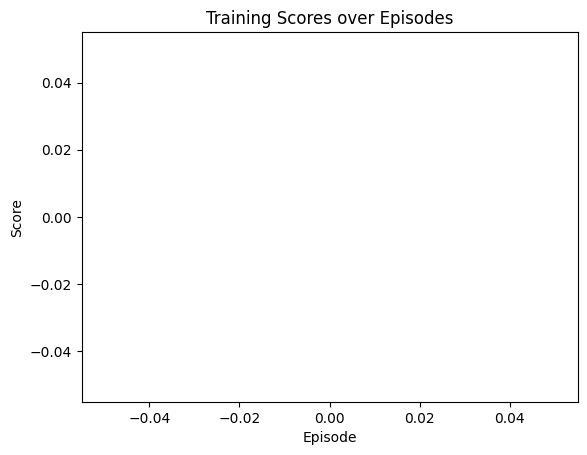

In [5]:
# Training the agent
agent = DQNAgent(state_size, action_size)
scores = agent.train(1, batch_size=32)

# Plotting the results
plt.plot(scores)
plt.title('Training Scores over Episodes')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()